In [56]:
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [57]:
class Wall:
    def __init__(self, x: float, number: int):
        self.x = x
        self.number = number

In [58]:
def account_walls(nodes: Nodes, particles: Particles, left: Wall, right: Wall):
    old_n = particles.n_macro
    particles.v = particles.v[particles.x >= left.x].copy()
    particles.x = particles.x[particles.x >= left.x].copy()
    particles.n_macro = len(particles.x)
    left.number += old_n - particles.n_macro
    old_n = particles.n_macro
    particles.v = particles.v[particles.x <= right.x].copy()
    particles.x = particles.x[particles.x <= right.x].copy()
    particles.n_macro = len(particles.x)
    right.number += old_n - particles.n_macro
    nodes.rho[round(left.x)] += left.number*particles.q
    nodes.rho[round(right.x)] += right.number*particles.q

In [59]:
temp_ion_fluxes = []
temp_electron_fluxes = []
temp_sum_fluxes = []

In [60]:
temps = []

In [61]:
for i in range(1, 21):
    L = 1e-2
    N_x = 200
    N_p = 5000
    h = L/N_x
    tau = 1e-13
    n0 = 1e17
    #concentrations.append(n0)
    n1 = n0*N_x/N_p
    q = 1.60217e-19
    m_e = 9.1093837e-31
    m_i = 1.672e-27
    epsilon = 8.85e-12
    T_e = 11600*i
    temps.append(T_e)
    T_i = 600
    k_b = 1.38e-23
    v_t_e = math.sqrt(3*k_b*T_e/m_e)
    vmin_e = -3*v_t_e
    vmax_e = 3*v_t_e
    v_t_i = math.sqrt(3*k_b*T_i/m_i)
    vmin_i = -3*v_t_i
    vmax_i = 3*v_t_i
    ions = Particles(N_p, n1, q, m_i)
    electrons = Particles(N_p, n1, -q, m_e)
    nodes = Nodes(N_x)
    left_wall = Wall(L/10/h, 0)
    right_wall = Wall(9*L/10/h, 0)

    set_homogeneous(electrons, left_wall.x*h, right_wall.x*h)
    set_homogeneous(ions, left_wall.x*h, right_wall.x*h)
    set_distr(electrons, Maxwell(T_e, k_b, m_e), vmin_e, vmax_e, 1000)
    set_distr(ions, Maxwell(T_i, k_b, m_i), vmin_i, vmax_i, 1000)
    electrons.normalise(h, tau)
    ions.normalise(h, tau)
    get_rho(nodes, electrons)
    get_rho(nodes, ions)
    calc_fields(nodes, h, epsilon)
    accel(electrons, nodes, L, h, tau, zerostep=True)
    accel(ions, nodes, L, h, tau, zerostep=True)
    n = 20000
    for t in tqdm(range(n)):
        try:
            move(electrons, nodes, consistency=True)
            move(ions, nodes, consistency=True)
        except Exception:
            print("number of iteration: ", t)
            break

        nodes.rho *= 0
        account_walls(nodes, electrons, left_wall, right_wall)
        account_walls(nodes, ions, left_wall, right_wall)
        get_rho(nodes, electrons)
        get_rho(nodes, ions)
        
        calc_fields(nodes, h, epsilon, periodic=True)
        accel(electrons, nodes, L, h, tau)
        accel(ions, nodes, L, h, tau)
        
        electrons.denormalise(h, tau)
        ions.denormalise(h, tau)
        electrons.normalise(h, tau)
        ions.normalise(h, tau)

    temp_electron_fluxes.append(N_p-electrons.n_macro)
    temp_ion_fluxes.append(N_p-ions.n_macro)
        

100%|██████████| 20000/20000 [04:18<00:00, 77.33it/s]


In [62]:
conc_ion_fluxes = []
conc_electron_fluxes = []
conc_sum_fluxes = []

In [63]:
concentrations = []

In [64]:
conc_k = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [65]:
for i in range(len(conc_k)):
    L = 1e-2
    N_x = 200
    N_p = 5000
    h = L/N_x
    tau = 1e-13
    n0 = 1e17*conc_k[i]
    concentrations.append(n0)
    n1 = n0*N_x/N_p
    q = 1.60217e-19
    m_e = 9.1093837e-31
    m_i = 1.672e-27
    epsilon = 8.85e-12
    T_e = 11600*20
    #temps.append(T_e)
    T_i = 600
    k_b = 1.38e-23
    v_t_e = math.sqrt(3*k_b*T_e/m_e)
    vmin_e = -3*v_t_e
    vmax_e = 3*v_t_e
    v_t_i = math.sqrt(3*k_b*T_i/m_i)
    vmin_i = -3*v_t_i
    vmax_i = 3*v_t_i
    ions = Particles(N_p, n1, q, m_i)
    electrons = Particles(N_p, n1, -q, m_e)
    nodes = Nodes(N_x)
    left_wall = Wall(L/10/h, 0)
    right_wall = Wall(9*L/10/h, 0)

    set_homogeneous(electrons, left_wall.x*h, right_wall.x*h)
    set_homogeneous(ions, left_wall.x*h, right_wall.x*h)
    set_distr(electrons, Maxwell(T_e, k_b, m_e), vmin_e, vmax_e, 1000)
    set_distr(ions, Maxwell(T_i, k_b, m_i), vmin_i, vmax_i, 1000)
    electrons.normalise(h, tau)
    ions.normalise(h, tau)
    get_rho(nodes, electrons)
    get_rho(nodes, ions)
    calc_fields(nodes, h, epsilon)
    accel(electrons, nodes, L, h, tau, zerostep=True)
    accel(ions, nodes, L, h, tau, zerostep=True)
    n = 20000
    for t in tqdm(range(n)):
        try:
            move(electrons, nodes, consistency=True)
            move(ions, nodes, consistency=True)
        except Exception:
            print("number of iteration: ", t)
            break

        nodes.rho *= 0
        account_walls(nodes, electrons, left_wall, right_wall)
        account_walls(nodes, ions, left_wall, right_wall)
        get_rho(nodes, electrons)
        get_rho(nodes, ions)
        
        calc_fields(nodes, h, epsilon, periodic=True)
        accel(electrons, nodes, L, h, tau)
        accel(ions, nodes, L, h, tau)
        
        electrons.denormalise(h, tau)
        ions.denormalise(h, tau)
        electrons.normalise(h, tau)
        ions.normalise(h, tau)

    conc_electron_fluxes.append(N_p-electrons.n_macro)
    conc_ion_fluxes.append(N_p-ions.n_macro)
        

100%|██████████| 20000/20000 [04:10<00:00, 79.95it/s]


In [75]:
temp_electron_fluxes = np.array(temp_electron_fluxes)
temp_ion_fluxes = np.array(temp_ion_fluxes)
conc_electron_fluxes = np.array(conc_electron_fluxes)
conc_ion_fluxes = np.array(conc_ion_fluxes)

In [76]:
temps = np.array(temps)
concentrations = np.array(concentrations)

Text(0.5, 1.0, 'Зависимость потока электронов от температуры электронов')

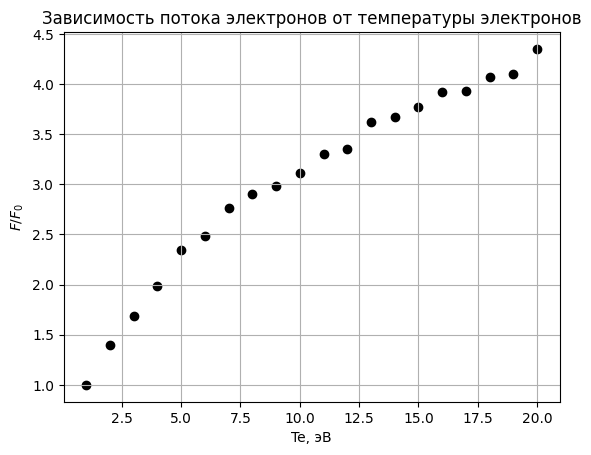

In [102]:
plt.scatter(temps/11600, temp_electron_fluxes/temp_electron_fluxes[0], color = "k")
plt.grid()
plt.xlabel("Te, эВ")
plt.ylabel(f"$F/F_0$")
plt.title("Зависимость потока электронов от температуры электронов")

Text(0.5, 1.0, 'Зависимость потока ионов от температуры электронов')

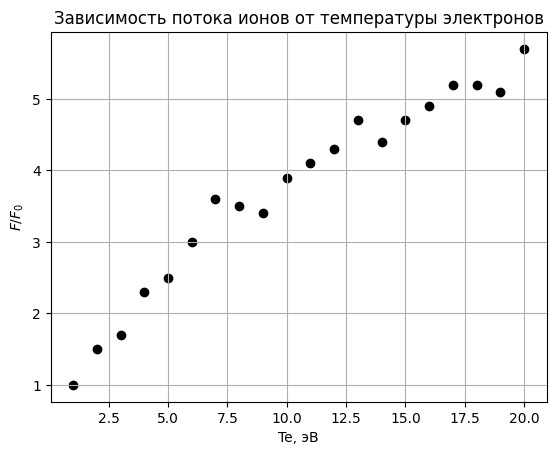

In [103]:
plt.scatter(temps/11600, temp_ion_fluxes/temp_ion_fluxes[0], color = "k")
plt.grid()
plt.xlabel("Te, эВ")
plt.ylabel(f"$F/F_0$")
plt.title("Зависимость потока ионов от температуры электронов")

Text(0.5, 1.0, 'Зависимость потока электронов от концентрации плазмы')

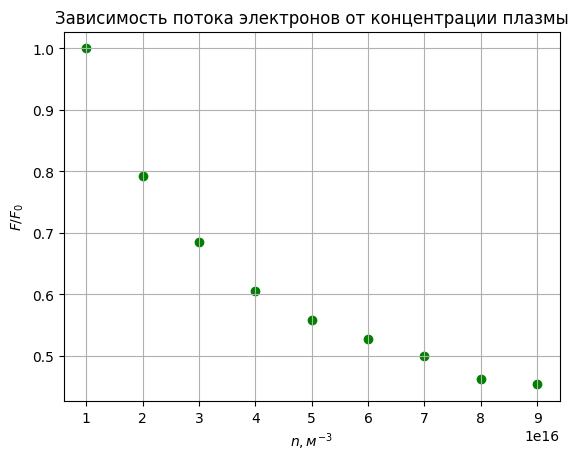

In [106]:
plt.scatter(concentrations, conc_electron_fluxes/conc_electron_fluxes[-1], color = "g")
plt.grid()
plt.xlabel(r"$n, м^{-3}$")
plt.ylabel(f"$F/F_0$")
plt.title("Зависимость потока электронов от концентрации плазмы")

Text(0.5, 1.0, 'Зависимость потока ионов от концентрации плазмы')

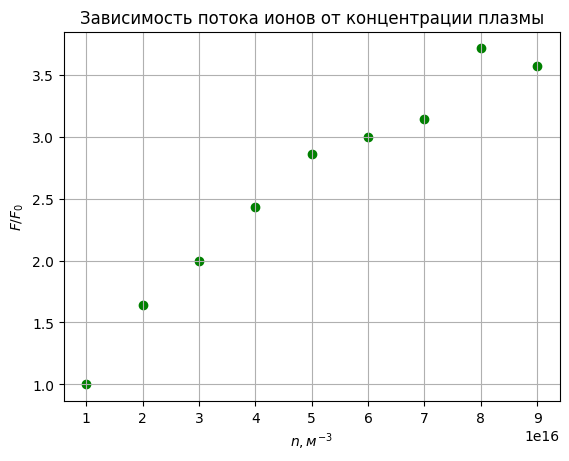

In [107]:
plt.scatter(concentrations, conc_ion_fluxes/conc_ion_fluxes[-1], color = "g")
plt.grid()
plt.xlabel(r"$n, м^{-3}$")
plt.ylabel(f"$F/F_0$")
plt.title("Зависимость потока ионов от концентрации плазмы")